In [29]:

import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.geometry import box
import numpy as np
import osmnx as ox
import tobler
import matplotlib.pyplot as plt
import rasterio
from rasterstats import zonal_stats
import ee
import geemap
from sklearn.preprocessing import MinMaxScaler
import jenkspy

ee.Initialize(project='ee-paulstrobel77')

## Create a Regular Grid from GDF


In [30]:
# define input gdf and gridsize, mind the projection units
def make_grid(input_gdf, grid_size):
    min_x, min_y, max_x, max_y = input_gdf.total_bounds
    bounding_box = box(min_x, min_y, max_x, max_y)

    x_cords = np.arange(min_x, max_x, grid_size)
    y_cords = np.arange(min_y, max_y, grid_size)

    grid_polygons = []

    for x in x_cords:
        for y in y_cords:
            square = shapely.geometry.box(x,y, x + grid_size, y + grid_size)
            grid_polygons.append(square)
        
    grid_gdf = gpd.GeoDataFrame({"geometry":grid_polygons},crs=input_gdf.crs)
    
    return grid_gdf

## Polygon to Pixel

In [31]:
# define input gdf and grid gdf, mind tobler converting float to object


def make_pxl(gdf, grid):
    variables = [col for col in gdf.columns if col != gdf.geometry.name]
    pixel_gdf = tobler.area_weighted.area_join(gdf, grid, variables=variables)
    mask = pixel_gdf[variables].isna().all(axis=1) # create mask for nan rows
    pixel_gdf = pixel_gdf[~mask].reset_index(drop=True) # keep all the rows which do not match with the mask
    return pixel_gdf

## Point Counts

In [32]:
# pass poly_gdf for point count, pass point_gdf, no_zeros: bool to define if you want to keep zeros or not

def count_points(poly_gdf, point_gdf, no_zeros):
    join = gpd.sjoin(point_gdf, poly_gdf, how = "inner", predicate="within")
    join_grouped = join.groupby("index_right", as_index = False).size()
    poly_point_count = poly_gdf.merge(join_grouped, left_index = True, right_on = "index_right", how = "left")
    poly_point_count = poly_point_count.rename(columns = {"size":"num_points"})
    poly_point_count["num_points"] =poly_point_count["num_points"].fillna(0)
    if no_zeros: 
        mask = poly_point_count["num_points"] == 0
        poly_point_count = poly_point_count[~mask].reset_index()
        return poly_point_count
    else:
        return poly_point_count

## Remap Values

In [33]:
def remap_values_min_max(df, column_name):
 
    col_min = df[column_name].min()
    col_max = df[column_name].max()

    df[f"{column_name}_remap"] = (df[column_name] - col_min) / (col_max - col_min)
    df[f"{column_name}_remap"] = df[f"{column_name}_remap"] * 4

    
    return df

In [34]:
def remap_values(df, column_name):
    col_min = df[column_name].min()
    col_max = df[column_name].quantile(0.99)

    # Check if the range is zero
    if col_max - col_min == 0:
        # Assign zero to all rows in the new column
        df[f"{column_name}_remap"] = 0
        return df

    # Remap values to the range [0, 1]
    df[f"{column_name}_remap"] = (df[column_name] - col_min) / (col_max - col_min)
    
    # Clip values to ensure they are in the range [0, 1]
    df[f"{column_name}_remap"] = df[f"{column_name}_remap"].clip(0, 1) * 4

    return df


In [35]:
cities = pd.read_csv("/Users/paulstrobel/Desktop/MaCT/3_Digital Catography/Practice/Data/Hot Cities/cities ml.csv")
geometry = [Point(x,y) for x,y in zip(cities["longitude"], cities["latitude"])]
cities = gpd.GeoDataFrame(data = cities, geometry=geometry, crs = "EPSG:4326")


In [36]:
# tags
green_tags = {
    "leisure": "park",
    "landuse":"forest"
    }
street_tags = {
    "highway":["primary", "secondary"]
    }
vul_tags = {
    "amenity": [
        "college",
        "clinic",
        "kindergarten",
        "library",
        "school",
        "clinic",
        "hospital",
        "nursing_home",
        "social_facility",
        "refugee_site",
        "social_centre",
        "childcare"
    ]
}
climate_tags = {
    "amenity": [
        "bench",
        "drinking_water",
        "shelter",
        "shower",
        "water_point",
        "watering_place"   
    ]
}
water_tags =  {
    "natural": "water",
}

# params
crs_proj = "EPSG:3857"
crs_geo = "EPSG:4326"
buffer = 15000
city_name = "Berlin"
focus_city = cities[cities["asciiname"] == city_name]
gridsize = 300

gridsize_1 = gridsize/4


In [37]:
# compute grid
bounds = focus_city.to_crs(crs_proj).geometry.buffer(buffer).total_bounds
grid = make_grid(gpd.GeoSeries(box(*bounds), crs=crs_proj), gridsize)
grid["point_geom"] = grid["geometry"].centroid

In [38]:
# OSM FEATURES

In [39]:
##  get OSM FEATURES
osm_feature_green = ox.features_from_point((focus_city["latitude"], focus_city["longitude"]),dist=buffer, tags=green_tags)
osm_feature_street = ox.features_from_point((focus_city["latitude"], focus_city["longitude"]),dist=buffer, tags=street_tags)
osm_feature_vul = ox.features_from_point((focus_city["latitude"], focus_city["longitude"]),dist=buffer, tags=vul_tags)
osm_feature_climate = ox.features_from_point((focus_city["latitude"], focus_city["longitude"]),dist=buffer, tags=climate_tags)
osm_feature_water = ox.features_from_point((focus_city["latitude"], focus_city["longitude"]),dist=buffer, tags=water_tags)

## load and clip OCEAN SHP
ocean = gpd.read_file("/Users/paulstrobel/Next Cloud/Freigaben/ArchSupply/04_Kartografie/GIS/_Geodaten/Welt-Natural Earth/10m_physical/ne_10m_ocean.shp")
ocean = ocean.to_crs(crs_geo)
grid = grid.to_crs(crs_geo)
minx, miny, maxx, maxy = grid.total_bounds  # Extract bounds
bbox = gpd.GeoDataFrame({'geometry': [box(minx, miny, maxx, maxy)]}, crs=grid.crs)
ocean_clipped = ocean.clip(bbox)

# integrate in one list
osm_feature_green = osm_feature_green.to_crs(crs_proj)
osm_feature_street = osm_feature_street.to_crs(crs_proj)
osm_feature_vul = osm_feature_vul.to_crs(crs_proj)
osm_feature_climate = osm_feature_climate.to_crs(crs_proj)
osm_feature_water = osm_feature_water.to_crs(crs_proj)
ocean_clipped = ocean_clipped.to_crs(crs_proj)
grid = grid.to_crs(crs_proj)

# green: filter according to large green areas
osm_feature_green["area"] = osm_feature_green["geometry"].area
osm_feature_green = osm_feature_green[osm_feature_green["area"] > 100000]

# water: combine ocean and osm filter according to large water areas
mask = osm_feature_water.geometry.geom_type == "Polygon"
osm_feature_water = osm_feature_water[mask]

osm_feature_water = pd.concat([osm_feature_water, ocean_clipped], ignore_index=True)
osm_feature_water = osm_feature_water.dissolve()  
osm_feature_water = osm_feature_water.explode(index_parts=False).reset_index(drop=True) 

osm_feature_water["area"] = osm_feature_water["geometry"].area 
osm_feature_water = osm_feature_water[osm_feature_water["area"] > 100000]

# compute park distance
grid = grid.to_crs(crs_proj)
grid = grid.set_geometry("point_geom")
green_grid = gpd.sjoin_nearest(grid, osm_feature_green, distance_col = "distance_green")
green_grid = green_grid.drop_duplicates(subset="geometry", keep="first")  

# compute water distance
grid = grid.set_geometry("point_geom")
blue_grid = gpd.sjoin_nearest(grid, osm_feature_water, distance_col = "distance_water")
blue_grid = blue_grid.drop_duplicates(subset="geometry", keep="first")  

# clean point features (osm_feature_vul, osm_feature_climate)
osm_list_point_feature = [osm_feature_vul, osm_feature_climate]
for i, layer in enumerate(osm_list_point_feature):
    mask = layer.geometry.geom_type == "Point"
    osm_list_point_feature[i] = layer[mask]

# compute heat maps VUL and CLIMATE Function 
grid = grid.set_geometry("geometry")
vul_grid = count_points(grid, osm_feature_vul, False)
vul_grid = vul_grid.reset_index(drop=True) # get rid of duplicate geometry (WHY ARE THEY THERE?)

climate_grid = count_points(grid, osm_feature_climate, False)
climate_grid = climate_grid.reset_index(drop=True) # get rid of duplicate geometry (WHY ARE THEY THERE?)

# integrate grid
vul_grid["cal_park_distance"] = green_grid["distance_green"]
vul_grid["cal_water_distance"] = blue_grid["distance_water"]
vul_grid["cal_climate_functions"] = climate_grid["num_points"]
vul_grid.rename(columns = {"num_points": "cal_vul_functions"}, inplace = True)
master_grid = vul_grid



/opt/anaconda3/envs/geoenvironment/lib/python3.12/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
/opt/anaconda3/envs/geoenvironment/lib/python3.12/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
/opt/anaconda3/envs/geoenvironment/lib/python3.12/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]
/opt/anaconda3/envs/geoenvironment/lib/python3.12/site-packages/shapely/geometry/polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeErr

In [40]:
## get ROAD DENSITY


grid = grid.to_crs(crs_geo)
west, south, east, north = grid.total_bounds

box_nsew = {
    "north": north,
    "south": south,
    "east": east,
    "west": west
    }

G = ox.graph_from_bbox(**box_nsew, simplify=True, retain_all=False, network_type="drive")

nodes, edges  = ox.graph_to_gdfs(G)

edges = edges.to_crs(crs_proj)
grid = grid.to_crs(crs_proj)

grid["grid_id"] = range(len(grid))
intersection = gpd.overlay(edges, grid, how = "intersection")
intersection["length"] = intersection.geometry.length
length_per_grid = intersection.groupby("grid_id", as_index = False)["length"].sum()
grid = grid.merge(length_per_grid, on ="grid_id", how  = "left")
grid["length"] = grid["length"].fillna(0)


# include value im mastergrid
master_grid["road_length"] = grid["length"]

/var/folders/nr/4xqq3l6s4ds1w7g3vzm32vt40000gn/T/ipykernel_77883/2526407077.py:14: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(**box_nsew, simplify=True, retain_all=False, network_type="drive")
/var/folders/nr/4xqq3l6s4ds1w7g3vzm32vt40000gn/T/ipykernel_77883/2526407077.py:14: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(**box_nsew, simplify=True, retain_all=False, network_type="drive")


## EARTH ENGINE

In [41]:
# visualise LCZ data

m = geemap.Map(center=[21.79, 70.87], zoom=3)
colors = [
    '8c0000','d10000','ff0000','bf4d00','ff6600',
    'ff9955','faee05','bcbcbc','ffccaa','555555',
    '006a00','00aa00','648525','b9db79','000000',
    'fbf7ae','6a6aff'
    ]
m.add_basemap("Esri.WorldImagery")
image_lcz = ee.ImageCollection("RUB/RUBCLIM/LCZ/global_lcz_map/latest").mosaic()
vis_params_1 = {
    "min" : 1,
    "max" : 17,
    "bands" :"LCZ",
    "palette": colors,  
}
m.add_layer(image_lcz, vis_params_1, "LCZ")

# visualise UHU data

colors = ['313695', '74add1', 'fed976', 'feb24c', 'fd8d3c', 'fc4e2a', 'e31a1c','b10026']

image_uhi = ee.Image("YALE/YCEO/UHI/UHI_yearly_pixel/v4/2018")
vis_params = {
    "min": -1.5,
    "max": 7.5,
    "bands" :"Daytime",
    "palette": colors,  
}
m.add_layer(image_uhi, vis_params, "UHI_DAY")

# visualise pop data
colors = ['24126c', '1fff4f', 'd4ff50']
image_pop = ee.ImageCollection("WorldPop/GP/100m/pop_age_sex_cons_unadj").mosaic()
vis_params = {
    "min": 0.0,
    "max": 50,
    "bands" :"population",
    "palette": colors,  
}
m.add_layer(image_pop, vis_params, "Pop")


image_tree = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3").filter(ee.Filter.date('2015-01-01'))

vis_params = {
    "min": 0.0,
    "max": 100,
    "bands" :"tree_canopy_cover",
    "palette": colors,  
}
m.add_layer(image_tree, vis_params, "tree")

image_pop_density = ee.Image('JRC/GHSL/P2023A/GHS_POP/2020')

vis_params = {
    "min": 0.0,
    "max": 100,
    "bands" :"population_count",
    "palette": colors,  
}

m.add_layer(image_pop_density, vis_params, "population density")

m

Map(center=[21.79, 70.87], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [42]:
# grab LOCAL CLIMATE ZONES from gee

name = "cal_lcz"
mode = "majority"
img_band = "LCZ"
scale = 100
raster_path = "/Users/paulstrobel/Jupyter Files/241126_Green Assesment/test_raster.tif"
image_lcz = ee.ImageCollection("RUB/RUBCLIM/LCZ/global_lcz_map/latest").mosaic()
image = ee.Image(image_lcz).select(img_band)

master_grid = master_grid.to_crs(crs_geo)  
master_grid = master_grid.set_geometry("geometry")
box_interest = master_grid.total_bounds  
region = ee.Geometry.BBox(*box_interest) # "*" to unpack array  

# export raster
geemap.ee_export_image(image, filename=raster_path, scale=scale, region=region.getInfo())

# open the raster
with rasterio.open(raster_path) as raster:
    band1 = raster.read(1)  # read first band

master_grid = master_grid.to_crs(raster.crs)

# grab raster
stats = zonal_stats(
    master_grid,                      
    raster_path,                      
    stats=mode,                 
    geojson_out=True                  # Must be at the END!
)

# create gdf 
master_grid = gpd.GeoDataFrame.from_features(stats)
master_grid = master_grid.set_crs(crs_geo)
master_grid = master_grid.rename(columns = {mode:name})

Generating URL ...
Please wait ...
Data downloaded to /Users/paulstrobel/Jupyter Files/241126_Green Assesment/test_raster.tif


In [43]:
# grab POPULATION DENSITY from gee

name = "cal_population"
mode = "mean"
img_band = "population"
scale = 100
raster_path = "/Users/paulstrobel/Jupyter Files/241126_Green Assesment/test_raster.tif"
image_pop = ee.ImageCollection("WorldPop/GP/100m/pop_age_sex_cons_unadj").mosaic()
image = image_pop.select(img_band)

box_interest = master_grid.total_bounds  
region = ee.Geometry.BBox(*box_interest) # "*" to unpack array  

# export the raster
geemap.ee_export_image(image, filename=raster_path, scale=100, region=region.getInfo())

# open the raster
with rasterio.open(raster_path) as src:
    master_grid = master_grid.to_crs(src.crs)  # Reproject to match raster CRS

# Perform zonal statistics
stats = zonal_stats(
    master_grid,                       
    raster_path,                       
    stats=mode,                
    geojson_out=True,
    all_touched = True
)

master_grid = gpd.GeoDataFrame.from_features(stats)
master_grid = master_grid.set_crs(crs_geo)
master_grid = master_grid.rename(columns = {mode:name})

Generating URL ...
Please wait ...
Data downloaded to /Users/paulstrobel/Jupyter Files/241126_Green Assesment/test_raster.tif


In [44]:
# grab VUL POPULATION  from gee

name = "cal_vul_pop"
mode = "mean"
img_band = "population"
scale = 100
raster_path = "/Users/paulstrobel/Jupyter Files/241126_Green Assesment/test_raster.tif"
image= ee.ImageCollection("WorldPop/GP/100m/pop_age_sex_cons_unadj").mosaic()


box_interest = master_grid.total_bounds  
region = ee.Geometry.BBox(*box_interest) # "*" to unpack array  

bands_younger_10 = ['M_0', 'M_1', 'M_5', 'F_0', 'F_1', 'F_5']
bands_older_65 = ['M_70', 'M_75', 'M_80', 'F_70', 'F_75', 'F_80']

image = image.select(bands_younger_10 + bands_older_65).reduce(ee.Reducer.sum())

# Export the summed raster
raster_path = "/Users/paulstrobel/Jupyter Files/241126_Green Assesment/test_raster.tif"
geemap.ee_export_image(
    ee_object=image,
    filename=raster_path,
    scale=scale,  
    region=region.getInfo()
)

# open the raster
with rasterio.open(raster_path) as src:
    master_grid = master_grid.to_crs(src.crs)  # Reproject to match raster CRS

# Perform zonal statistics
stats = zonal_stats(
    master_grid,                       
    raster_path,                       
    stats=mode,                
    geojson_out=True,  
    all_touched = True
               
)

master_grid = gpd.GeoDataFrame.from_features(stats)
master_grid = master_grid.set_crs(crs_geo)
master_grid = master_grid.rename(columns = {mode:name})




Generating URL ...
Please wait ...
Data downloaded to /Users/paulstrobel/Jupyter Files/241126_Green Assesment/test_raster.tif


In [45]:
# grab UHI from gee

# fill parameter
name = "cal_uhi_day"
mode = "mean"
img_band = "Daytime"
scale = 300
raster_path = "/Users/paulstrobel/Jupyter Files/241126_Green Assesment/test_raster.tif"
image = ee.Image("YALE/YCEO/UHI/UHI_yearly_pixel/v4/2018").select(img_band)


region = ee.Geometry.BBox(*master_grid.total_bounds)

# compute the min and max values over the region
stats = image.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=region,
    scale=scale,  # Match your desired resolution
    bestEffort=True  # Efficient calculation
)

# Extract min and max values
min_value = stats.get('Daytime_min').getInfo()
max_value = stats.get('Daytime_max').getInfo()


# Normalize and scale the image dynamically to 0–4 range
image_remap = image.unitScale(min_value, max_value).multiply(4)

# Export  raster
geemap.ee_export_image(
    image_remap,
    filename=raster_path,
    scale=scale,
    region=region.getInfo()
)

# open the raster
with rasterio.open(raster_path) as src:
    master_grid = master_grid.to_crs(src.crs)  # Reproject to match raster CRS

# perform zonal statistics
stats = zonal_stats(
    master_grid,                       
    raster_path,                       
    stats=mode,                
    geojson_out=True,
    all_touched = True,
    nodata = 0
)

master_grid = gpd.GeoDataFrame.from_features(stats)
master_grid = master_grid.set_crs(crs_geo)
master_grid = master_grid.rename(columns = {mode:name})

master_grid[name].fillna(0, inplace = True)





Generating URL ...
Please wait ...
Data downloaded to /Users/paulstrobel/Jupyter Files/241126_Green Assesment/test_raster.tif


In [46]:
# grab TREE COVER from gee

# fill parameter
img_band = "tree_canopy_cover"
mode = "mean"
raster_path = "/Users/paulstrobel/Jupyter Files/241126_Green Assesment/test_raster.tif"
img_scale = 300
name = "cal_tree"
image = ee.ImageCollection("NASA/MEASURES/GFCC/TC/v3").filter(ee.Filter.date('2015-01-01')).mosaic()


# export raster
geemap.ee_export_image(image, filename=raster_path, scale=img_scale, region=region.getInfo())

# open the raster
with rasterio.open(raster_path) as src:
    master_grid = master_grid.to_crs(src.crs)  # Reproject to match raster CRS

# perform zonal statistics
stats = zonal_stats(
    master_grid,                       
    raster_path,                       
    stats=mode,                
    geojson_out=True,
    all_touched = True
    
    
)

master_grid = gpd.GeoDataFrame.from_features(stats)
master_grid = master_grid.set_crs(crs_geo)
master_grid = master_grid.rename(columns = {mode:name})

Generating URL ...
Please wait ...
Data downloaded to /Users/paulstrobel/Jupyter Files/241126_Green Assesment/test_raster.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


def remap_values_min_max_cap(df, column_name):
    # Calculate the min and max of the column (ignoring zeros)
    col_min = df[column_name][df[column_name] != 0].min()
    col_max = df[column_name][df[column_name] != 0].max()

    # Apply Min-Max scaling row by row with condition
    def scale_value(value):
        if value == 0:
            return 0  # Leave zero unchanged
        return (value - col_min) / (col_max - col_min) * 4  # Scale to range [0, 4]

    # Apply the scaling function to each row
    df[f"{column_name}_remap"] = df[column_name].apply(scale_value)
    
    return df



def remap_values_fin(df, column_name):
    col_min = df[column_name][df[column_name] != 0].min()
    col_max = df[column_name][df[column_name] != 0].max()

    # Apply Min-Max scaling row by row with condition
    def scale_value(value):
        if value <= 0:
            return 0  # Leave below zero unchanged
        return (value - col_min) / (col_max - col_min) * 4  # Scale to range [0, 4]

    # Apply the scaling function to each row
    df[f"{column_name}_remap"] = df[column_name].apply(scale_value)
    
    return df

In [47]:
def remap_values_jenks(df, column_name, n_classes):
    """
    Remap values based on Jenks Natural Breaks and scale the remapped values to [0.5, 4].

    Parameters:
    - df: DataFrame containing the data.
    - column_name: The column to remap.
    - n_classes: Number of Jenks classes.

    Returns:
    - DataFrame with a new column containing the remapped values.
    """
    # Check if column exists
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Get the non-zero values
    non_zero_values = df.loc[df[column_name] > 0, column_name].values

    # Check the number of unique non-zero values
    unique_values = np.unique(non_zero_values)
    if len(unique_values) < n_classes:
        n_classes = len(unique_values)  # Adjust n_classes to the number of unique values

    # Compute Jenks Natural Breaks
    breaks = jenkspy.jenks_breaks(non_zero_values, n_classes)

    # Define the scaling range [0.5, 4]
    min_val, max_val = 0.0, 4

    # Define a function to map each value to a class and then scale
    def scale_value(value):
        if value == 0:
            return 0  # Leave zero unchanged
        for i in range(1, len(breaks)):
            if breaks[i - 1] <= value < breaks[i]:
                # Map class index to [0.5, 4]
                scaled_class = min_val + (i - 1) / (n_classes - 1) * (max_val - min_val)
                return scaled_class
        return max_val  # Assign max value if it's in the last class

    # Apply the scaling function to the column
    df[f"{column_name}_remap"] = df[column_name].apply(scale_value)

    return df


In [48]:
### REMAP and SYN

#  remap functionn
syn_grid = master_grid.copy()

def remap_values_min_max(df, column_name):
    scaler = MinMaxScaler(feature_range=(0, 1))  # Scale to range [0, 4]
    df[f"{column_name}_remap"] = scaler.fit_transform(df[[column_name]]).clip(0, 1) * 4
    return df

# filter outliers and remap function
def remap_values(df, column_name):
    col_min = df[column_name].min()
    col_max = df[column_name].quantile(0.98)
    
    # Handle cases where col_max is equal to col_min and clip
  
    df[f"{column_name}_remap"] = (df[column_name] - col_min) / (col_max - col_min)
    df[f"{column_name}_remap"] = df[f"{column_name}_remap"].clip(0,1) * 4
    
    return df


## Remap RELIEF SYSTEM
syn_grid = remap_values_min_max(syn_grid, "cal_tree")
syn_grid = remap_values_jenks(syn_grid, "cal_climate_functions", 10) # remap point distribution which are likey very skewed with jenks? 

syn_grid["cal_park_remap"] = syn_grid["cal_park_distance"].apply(
    lambda x: 4 if x <= 100 else 
    (3 if x > 100 and x <= 300 else 
    (2 if x > 300 and x <= 500 else
    (1 if x > 500 and x <= 700 else 0))))

syn_grid["cal_water_remap"] = syn_grid["cal_water_distance"].apply(
    lambda x: 4 if x <= 100 else 
    (3 if x > 100 and x <= 300 else 
    (2 if x > 300 and x <= 500 else
    (1 if x > 500 and x <= 700 else 0))))


# Syn RELIEF SYSTEM
syn_grid["syn_relief"] = syn_grid["cal_tree_remap"] + syn_grid["cal_climate_functions_remap"] + syn_grid["cal_water_remap"] + (syn_grid["cal_park_remap"])
syn_grid = remap_values_min_max(syn_grid, "syn_relief")

## Remap VULNERABILITIES
syn_grid = remap_values(syn_grid, "cal_population")
# syn_grid= remap_values(syn_grid, "cal_vul_population")
syn_grid = remap_values_jenks(syn_grid, "cal_vul_functions", 10) # remap point distribution which are likey very skewed with jenks?  ASK IACOPO! MERGE WITH FUNCTIONS?

# Syn VULNERABILITIES
syn_grid["syn_vul"] = syn_grid["cal_population_remap"] + syn_grid["cal_vul_functions_remap"] # + syn_grid["cal_vul_population_remap"]
syn_grid = remap_values_min_max(syn_grid, "syn_vul")

## Remap UHI 
syn_grid["syn_uhi_day_remap"] = syn_grid["cal_uhi_day"]


## Remap URBAN FORM 

# mapping dict based on https://ars.els-cdn.com/content/image/1-s2.0-S0360132324010679-gr5.jpg
lcz_dict = {
    1.0: 10, 
    2.0: 23, 
    3.0: 19, 
    4.0: 5, 
    5.0: 4.5, 
    6.0: 5, 
    7.0: 4, 
    8.0: 12, 
    9.0: 1, 
    10.0: 14, 
    11.0: 0, 
    12.0: 0, 
    13.0: 0, 
    14.0 : 0, 
    15.0: 4, 
    16.0: 1, 
    17.0: 0, 
    0.0: 0
    }
syn_grid["cal_lcz_heat"] = syn_grid["cal_lcz"].map(lcz_dict)
syn_grid = remap_values_min_max(syn_grid, "cal_lcz_heat")
syn_grid = remap_values_min_max(syn_grid, "road_length")

#Syn URBAN FORM
syn_grid["syn_form"] = syn_grid["cal_lcz_heat_remap"] + syn_grid["road_length_remap"]
syn_grid = remap_values_min_max(syn_grid, "syn_form")

## Syn TOTAL v1
syn_grid["syn_total"] = ((syn_grid["syn_uhi_day_remap"] * 2) + ((syn_grid["syn_vul_remap"]) + syn_grid["syn_form_remap"]) - syn_grid["syn_relief_remap"])
syn_grid = remap_values_min_max(syn_grid, "syn_total")

## Syn TOTAL v1
syn_grid["syn_total_b"] = ((syn_grid["syn_uhi_day_remap"] * 1) + ((syn_grid["syn_vul_remap"]) + syn_grid["syn_form_remap"]) - syn_grid["syn_relief_remap"])
syn_grid = remap_values_min_max(syn_grid, "syn_total_b")

(1476353.370867919, 1509353.370867919, 6878999.31286198, 6911999.312861979)

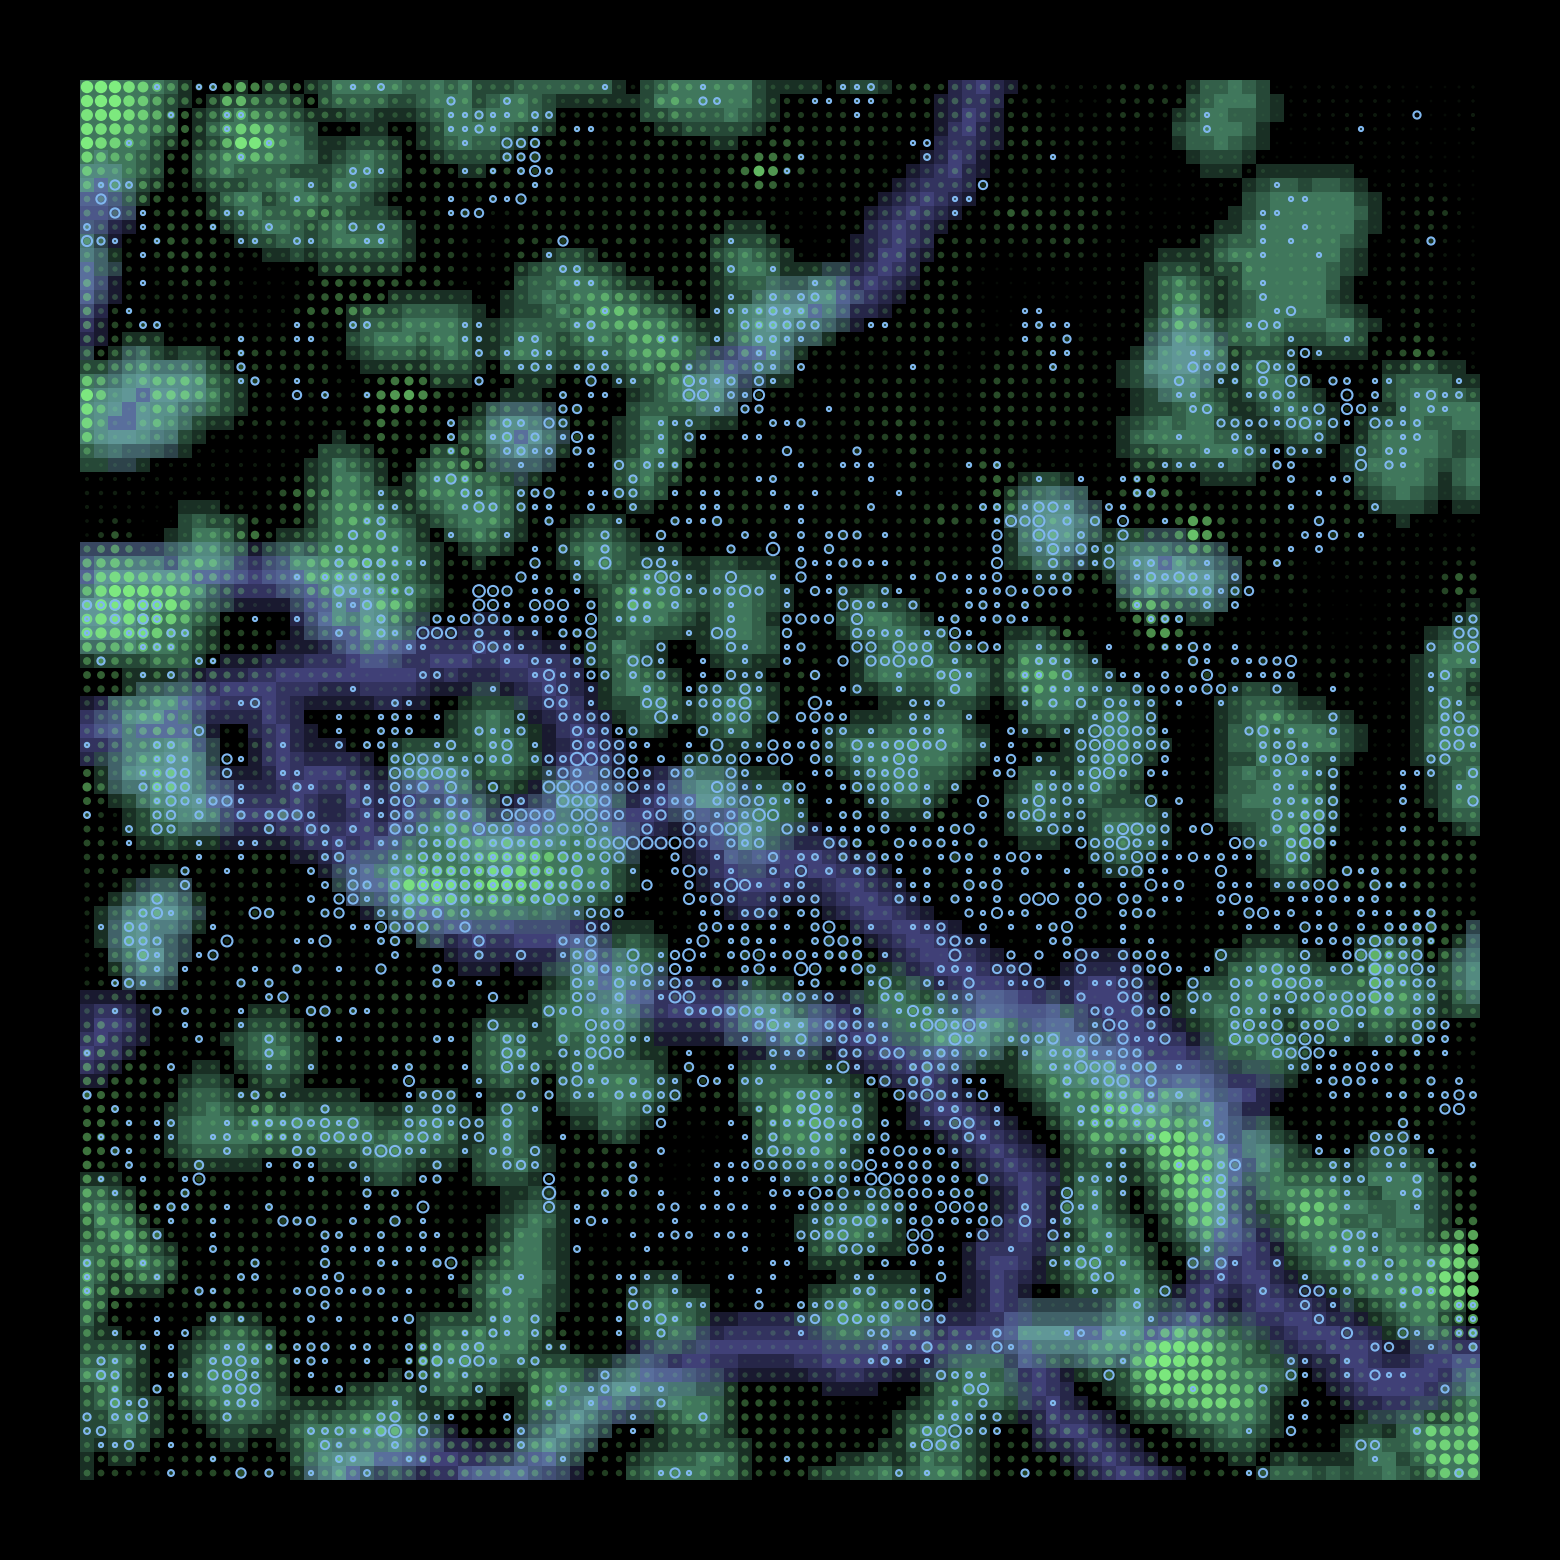

In [ ]:
fig, ax = plt.subplots(figsize = (20,20))
ax.set_facecolor('black')
fig.patch.set_facecolor('black')

edges = edges.to_crs(crs_proj)
syn_grid = syn_grid.to_crs(crs_proj)
syn_grid["point_geom"] = syn_grid.geometry.centroid

# edges.plot(ax=ax, zorder = 1, edgecolor = "white", alpha = 0.2, linewidth = 0.75)     
syn_grid[syn_grid["cal_water_remap"] == 1].dissolve().plot(zorder = 2, ax = ax,facecolor = "#8080EF", alpha = 0.2)
syn_grid[syn_grid["cal_water_remap"] == 2].dissolve().plot(zorder = 3,ax = ax,facecolor = "#8080EF", alpha = 0.3)
syn_grid[syn_grid["cal_water_remap"] == 3].dissolve().plot(zorder = 4,ax = ax,facecolor = "#8080EF", alpha = 0.4)
syn_grid[syn_grid["cal_water_remap"] == 4].dissolve().plot(zorder = 5, ax = ax,facecolor = "#8080EF", alpha = 0.5)
# syn_grid.plot(ax = ax, zorder = 1, column = "cal_water_remap")  

syn_grid[syn_grid["cal_park_remap"] == 1].dissolve().plot(zorder = 2, ax = ax,facecolor = "#80EFB8", alpha = 0.2)
syn_grid[syn_grid["cal_park_remap"] == 2].dissolve().plot(zorder = 3,ax = ax,facecolor = "#80EFB8", alpha = 0.3)
syn_grid[syn_grid["cal_park_remap"] == 3].dissolve().plot(zorder = 4,ax = ax,facecolor = "#80EFB8", alpha = 0.4)
syn_grid[syn_grid["cal_park_remap"] == 4].dissolve().plot(zorder = 5, ax = ax,facecolor = "#80EFB8", alpha = 0.5)

syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["cal_tree_remap"]*20, color = "#80EF80", edgecolor = "none", alpha = syn_grid["cal_tree_remap"]/4)
syn_grid_climate = syn_grid[syn_grid["cal_climate_functions_remap"] >0]
syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 7,markersize = syn_grid["cal_climate_functions_remap"]*20, color = "none", edgecolor = "#80B7EF", linewidth = 1.5)
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["syn_total_remap"]*20, color = "none", edgecolor = "white") # alpha = syn_grid["syn_total_remap"]/4)
ax.axis("off")

ax.axis("off")

In [50]:
# prepare export grid
old_names = list(syn_grid.columns)
new_names = ["geometry", "point_geom", "index_right", "v_funct", "r_park", "r_water", "r_clim", "f_road", "f_lcz", "v_pop", "v_pop_vul", "h_uhi", "r_tree", "r_tree_rm", "r_clim_rm", "r_park_rm", "r_water_rm", "syn_r", "syn_r_rm", "v_pop_rm", "v_funct_rm", "syn_v", "syn_v_rm", "syn_h_rm", "f_lcz_heat", "f_lcz_rm", "f_road_rm", "syn_f", "syn_f_rm", "syn_tot", "syn_tot_rm","syn_totb", "syn_totb_rm"]
rename_dict = {old_name:new_name for old_name, new_name in zip(old_names, new_names)}
exp_grid = syn_grid.copy()
exp_grid.rename(columns = rename_dict, inplace = True)
exp_grid.drop(columns = "point_geom", inplace = True)
exp_grid.to_file(f"{city_name}")


In [51]:
pd.Series(syn_grid.columns).to_csv("columns_old.csv", index=False, header=False)
pd.Series(new_names).to_csv("columns_new.csv", index=False, header=False)
pd.Series(exp_grid.columns).to_csv("columns_test.csv", index=False, header=False)



In [52]:
syn_grid["cal_vul_functions"].value_counts(dropna = False)



cal_vul_functions
0.0    8369
1.0    1130
2.0     351
3.0      96
4.0      35
5.0      11
6.0       5
7.0       3
Name: count, dtype: int64

(1476518.3708679187, 1509188.370867919, 6879164.312861979, 6911834.312861979)

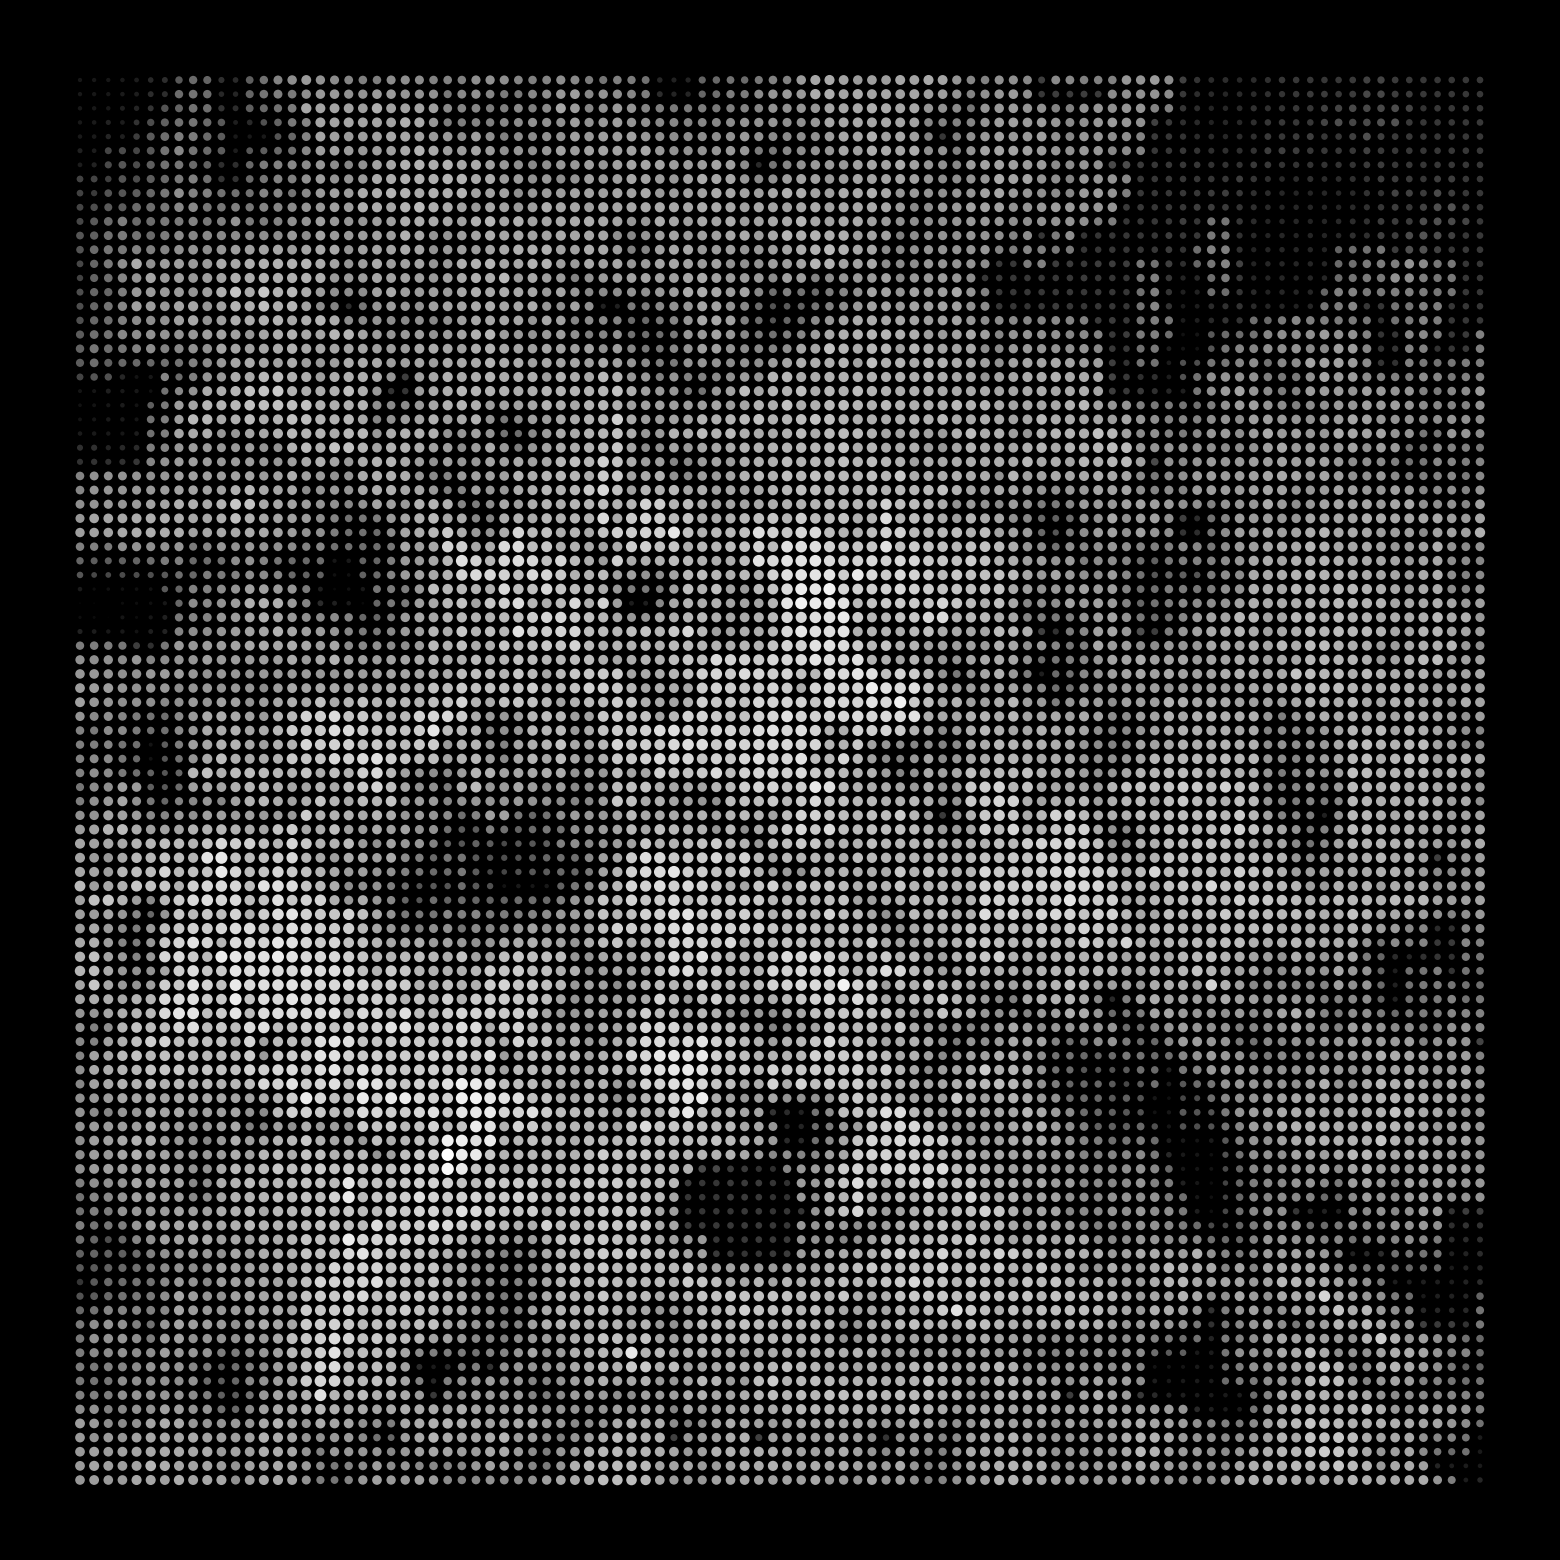

In [59]:
fig, ax = plt.subplots(figsize = (20,20))
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
edges = edges.to_crs(crs_proj)
syn_grid = syn_grid.to_crs(crs_proj)
syn_grid["point_geom"] = syn_grid.geometry.centroid

master_grid = master_grid.to_crs(crs_proj)
master_grid["point_geom"] = master_grid.geometry.centroid
# edges.plot(ax=ax, zorder = 1, edgecolor = "white", alpha = 0.2, linewidth = 0.75)     
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["syn_vul_remap"]*50, color = "white", edgecolor = "none", alpha = syn_grid["syn_vul_remap"]/4)
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["syn_relief_remap"]*30, color = "white", edgecolor = "none", alpha = syn_grid["syn_relief_remap"]/4)
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["syn_uhi_remap"]*50, color = "white", edgecolor = "none", alpha = syn_grid["syn_uhi_remap"]/4)
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["cal_uhi_day_remap"]*20, color = "white", edgecolor = "none", alpha = syn_grid["cal_uhi_day_remap"]/4)
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = (syn_grid["cal_uhi_day"] + 1)*20, color = "white", edgecolor = "none", alpha = syn_grid["cal_uhi_day"]/4)
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["syn_uhi_day_remap"]*20, color = "white", edgecolor = "none", alpha = syn_grid["syn_uhi_day_remap"]/4)
syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["syn_total_b_remap"]*20, color = "white", edgecolor = "none", alpha = syn_grid["syn_total_remap"]/4)
ax.axis("off")


<Axes: >

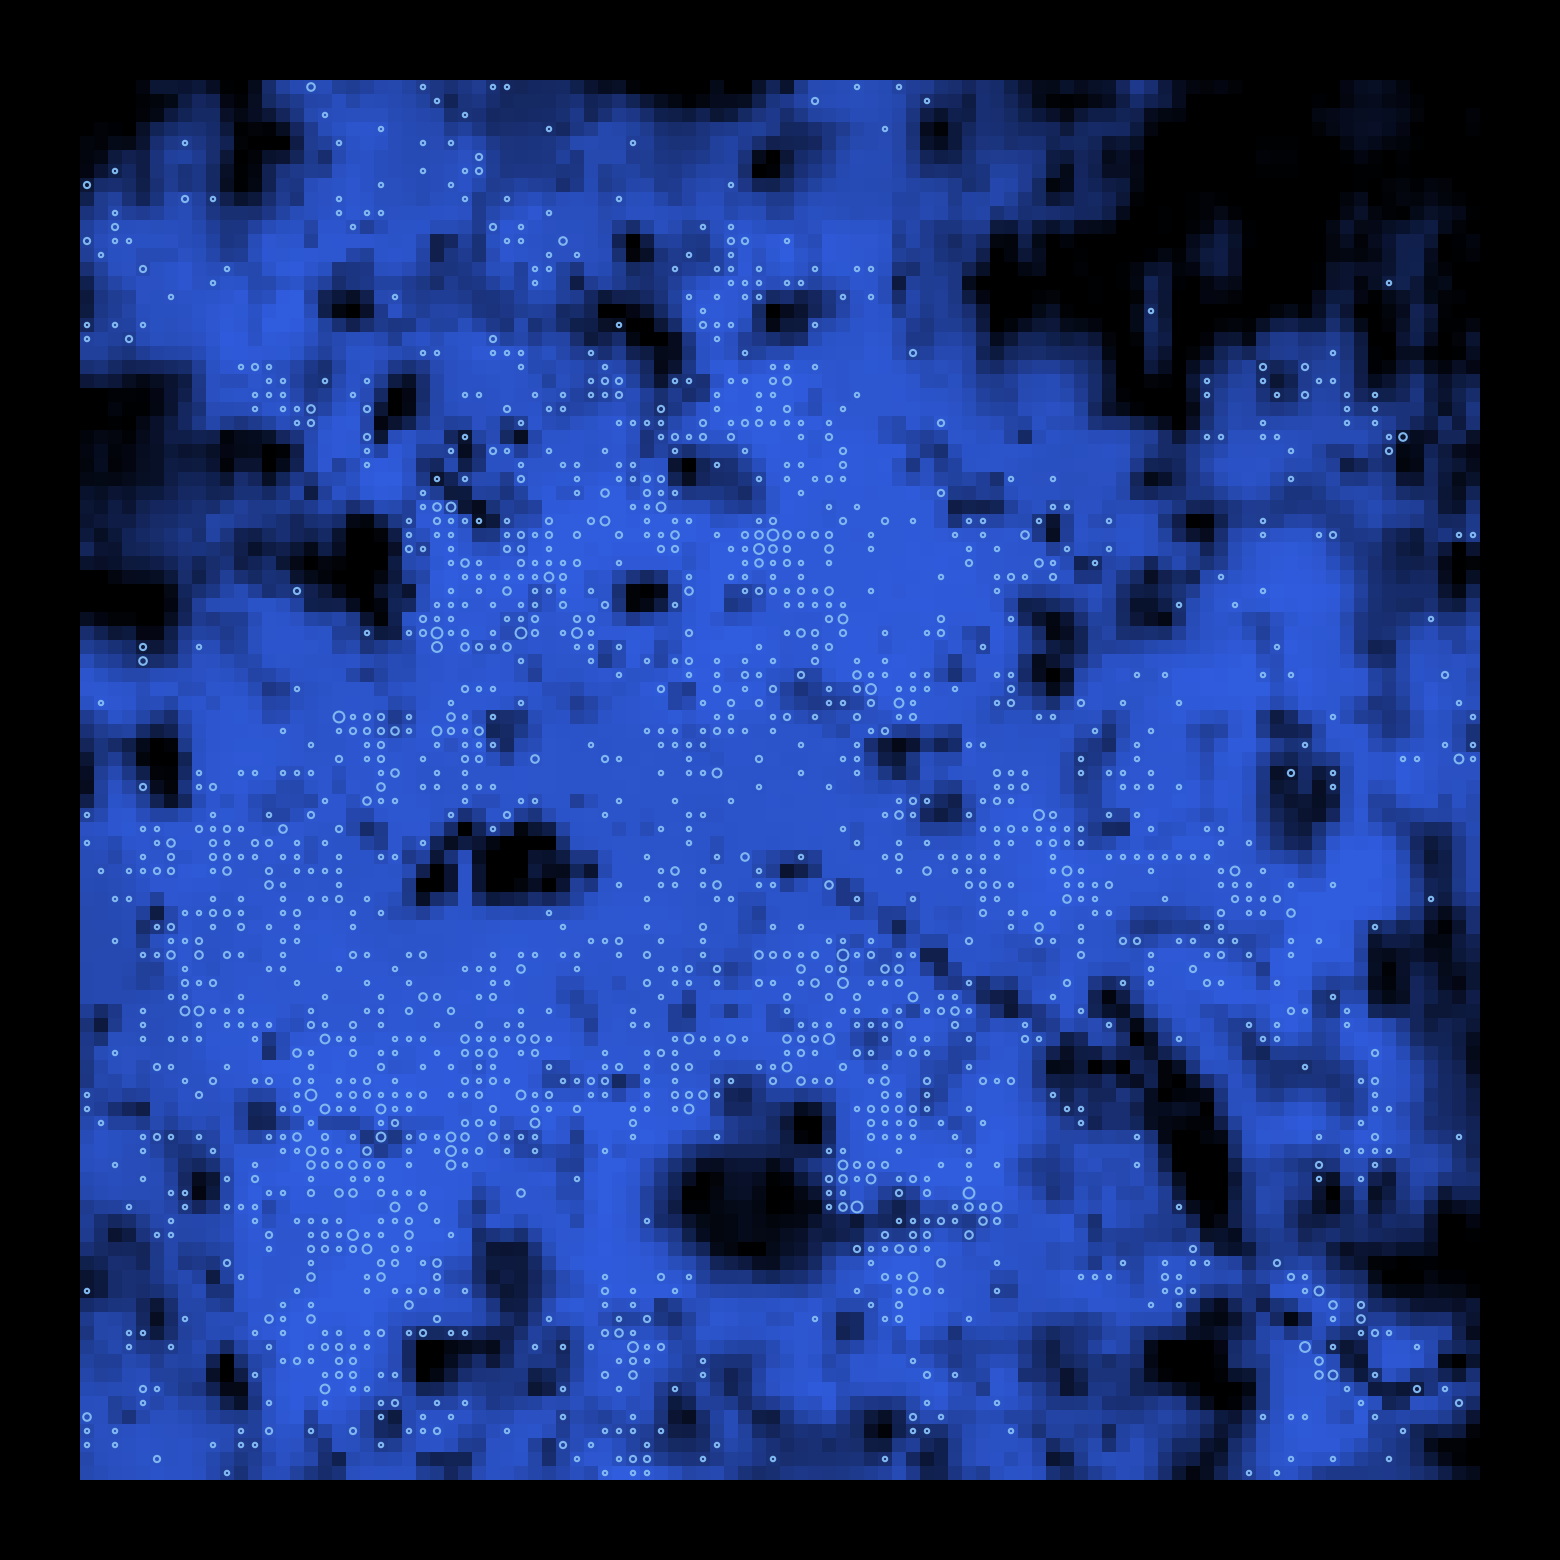

In [54]:
fig, ax = plt.subplots(figsize = (20,20))
ax.set_facecolor('black')
fig.patch.set_facecolor('black')
ax.axis("off")

edges = edges.to_crs(crs_proj)
syn_grid = syn_grid.to_crs(crs_proj)
syn_grid["point_geom"] = syn_grid.geometry.centroid


syn_grid.plot(ax = ax, zorder = 1, color = "#305cde", edgecolor = "none", alpha = (syn_grid["cal_population_remap"]/4))
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 1, markersize = syn_grid["cal_vul_population_remap"]*7.5, color = "#31c9de", edgecolor = "none", alpha = syn_grid["cal_vul_population_remap"]/4, marker = "s")

syn_grid_vul = syn_grid[syn_grid["cal_vul_functions_remap"] > 0]
syn_grid_vul.set_geometry("point_geom").plot(ax = ax, zorder = 2,markersize = syn_grid_vul["cal_vul_functions_remap"]*15, color = "none", edgecolor = "#80B7EF", linewidth = 1.5)


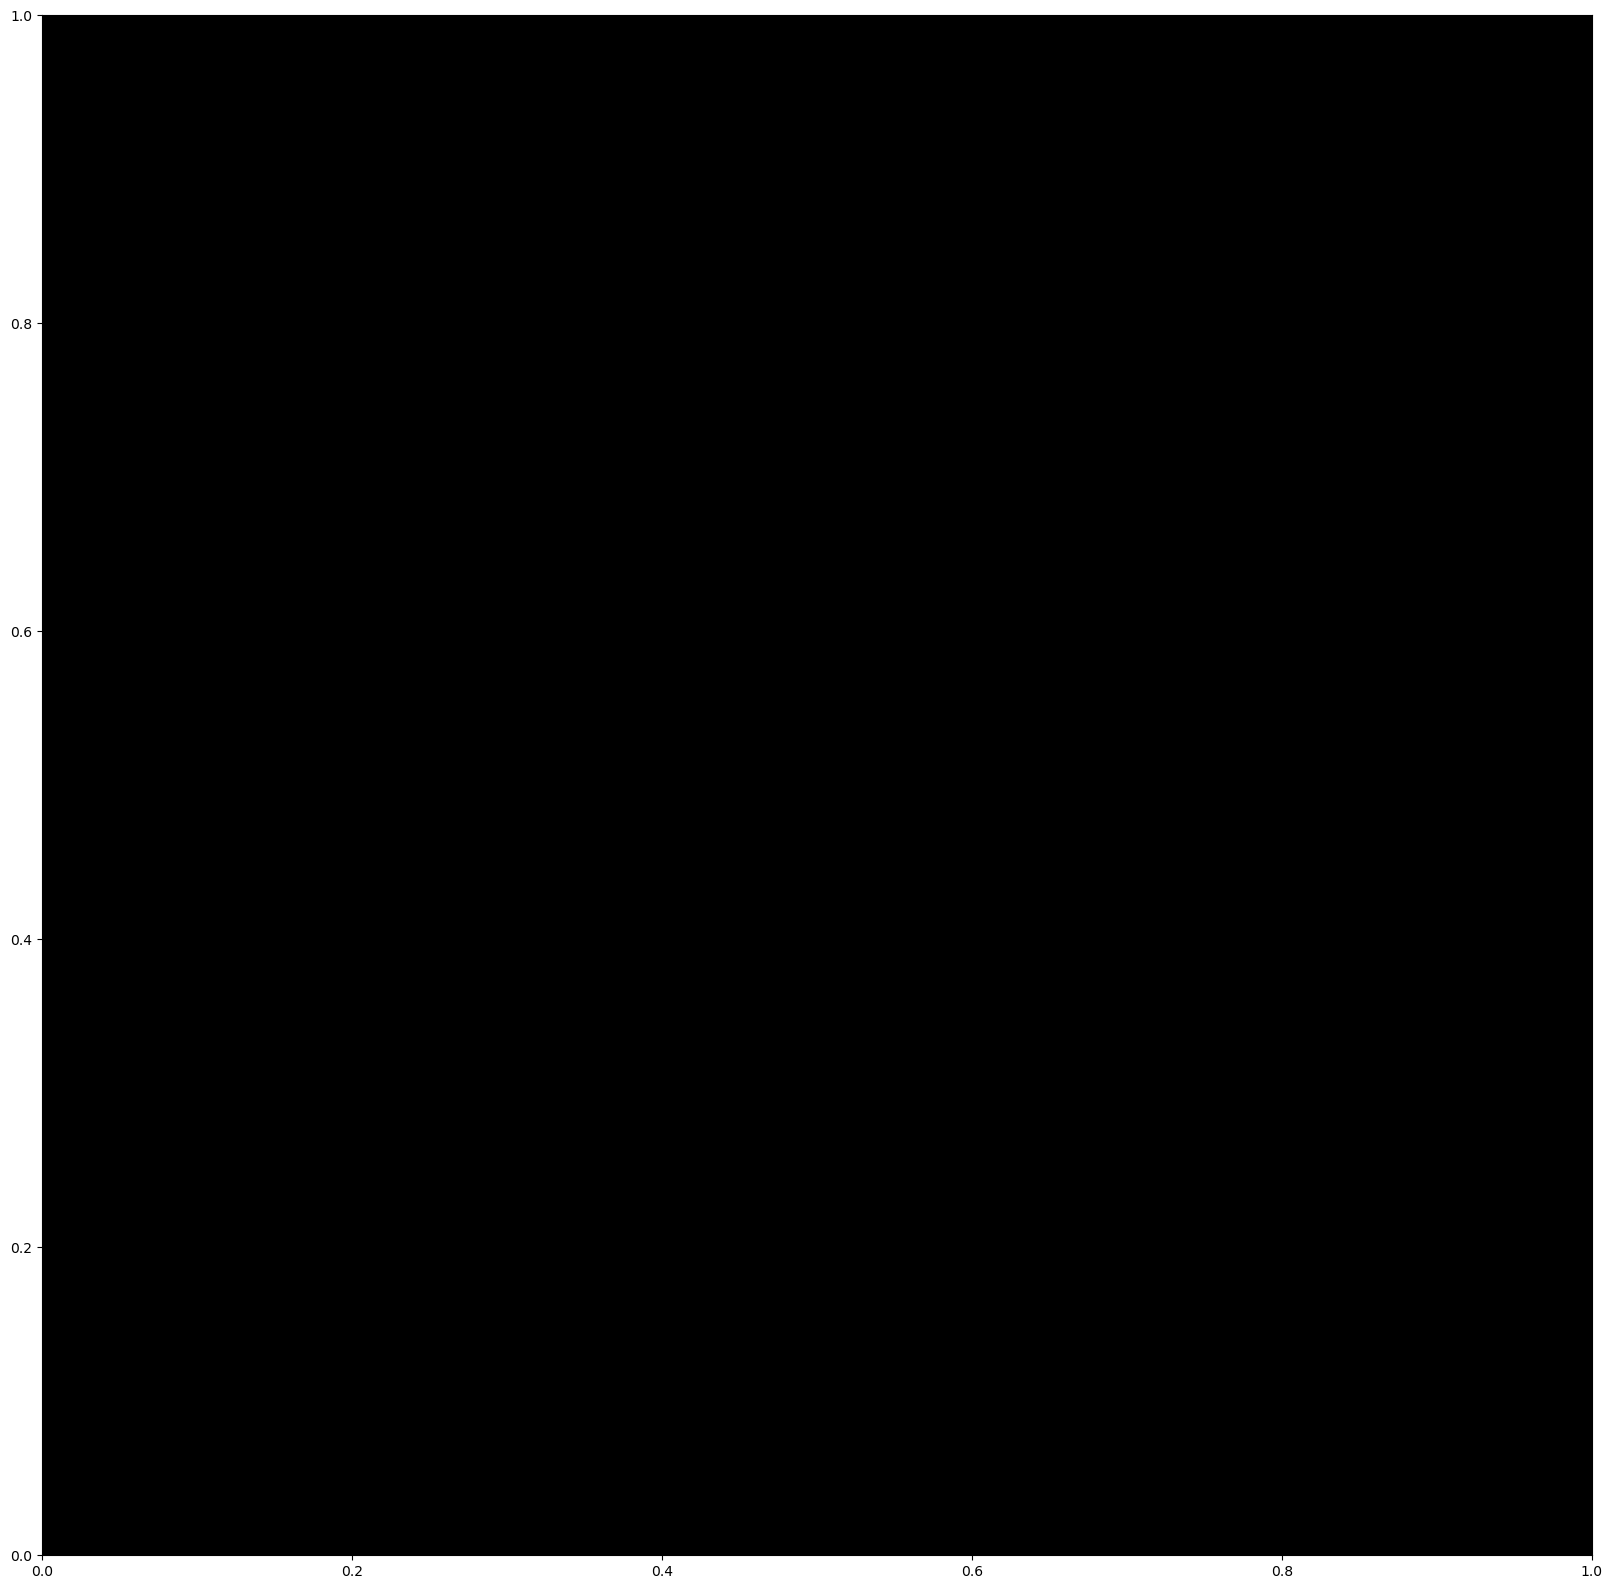

In [55]:
fig, ax = plt.subplots(figsize = (20,20))
ax.set_facecolor('black')
edges = edges.to_crs(crs_proj)
syn_grid = syn_grid.to_crs(crs_proj)
syn_grid["point_geom"] = syn_grid.geometry.centroid

# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["syn_uhi_day_remap"]*20, color = "white", edgecolor = "none", alpha = syn_grid["syn_uhi_day_remap"]/4)
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["syn_form_remap"]*20, color = "white", edgecolor = "none", alpha = syn_grid["syn_form_remap"]/4)
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["cal_uhi"]*20, color = "white", edgecolor = "none", alpha = syn_grid["syn_form_remap"]/4)

# edges.plot(ax=ax, zorder = 1, edgecolor = "white", alpha = 0.2, linewidth = 0.75)     
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["syn_vul_remap"]*20, color = "white", edgecolor = "none", alpha = syn_grid["syn_vul_remap"]/4)
# syn_grid.set_geometry("point_geom").plot(ax = ax, zorder = 6, markersize = syn_grid["syn_relief_remap"]*50, color = "white", edgecolor = "none", alpha = syn_grid["syn_relief_remap"]/4)


<Axes: >

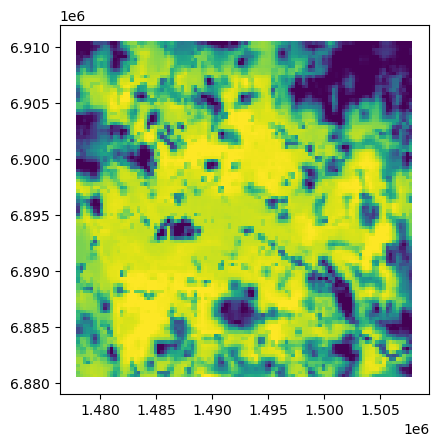

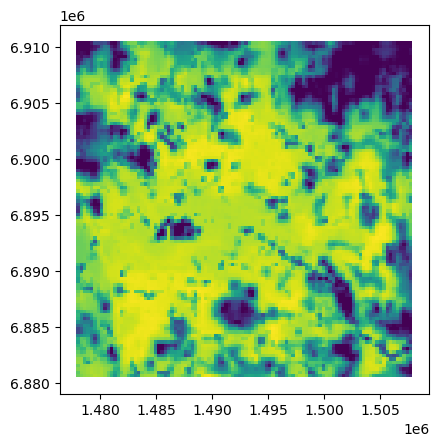

In [56]:
syn_grid.plot(column = "cal_population_remap")
syn_grid.plot(column = "cal_population")



<Axes: >

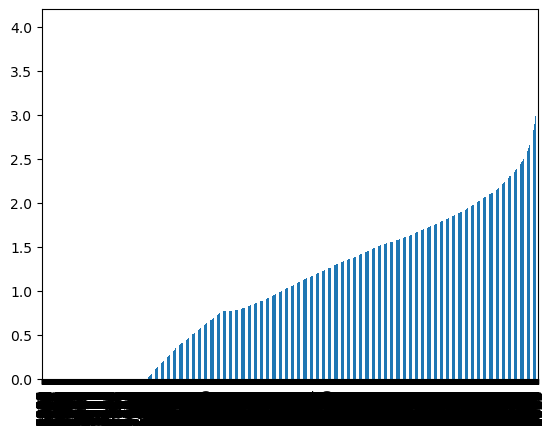

In [57]:
syn_grid["road_length_remap"].sort_values().plot.bar()

<Axes: >

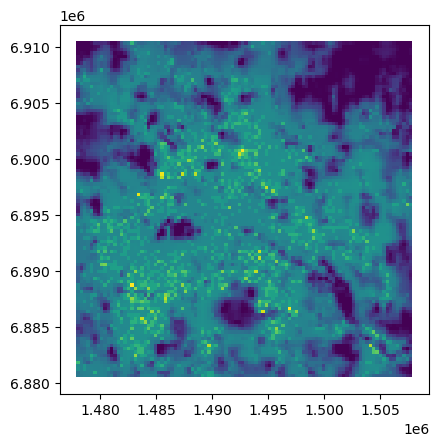

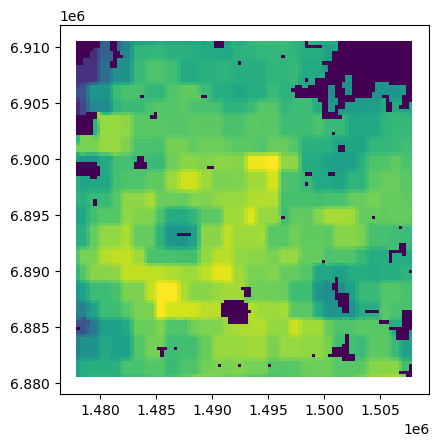

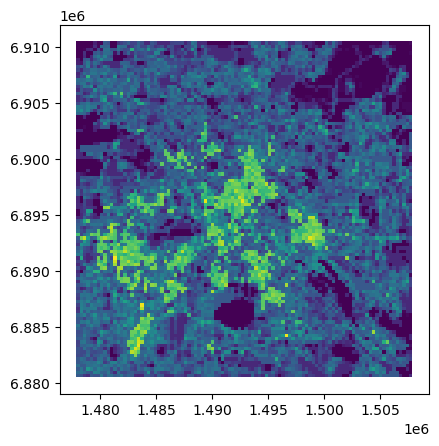

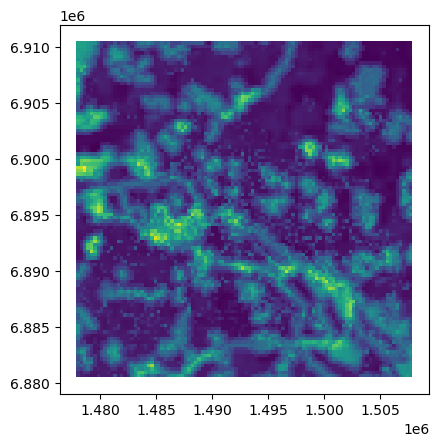

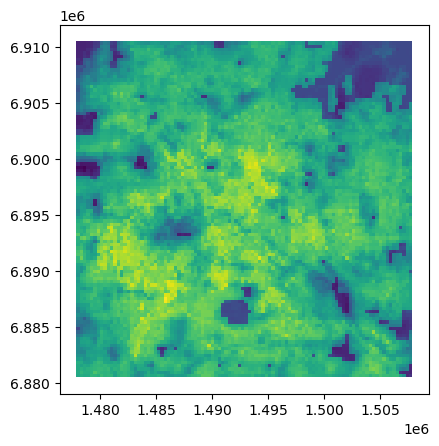

In [58]:
syn_grid.plot(column = "syn_vul_remap")
syn_grid.plot(column = "syn_uhi_day_remap")
syn_grid.plot(column = "syn_form_remap")
syn_grid.plot(column = "syn_relief_remap")
syn_grid.plot(column = "syn_total_remap")